# Baseline FMDT one sample at a time


In [93]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph
from collections import OrderedDict


%matplotlib inline

In [120]:
fc = 1.12 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 16 # number of DM trials
Nchan= 16
Nt = 256 # time block size
Tint = 0.864e-3 # integration time - seconds
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = constants.c/f1/1e9
lam2 = constants.c/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2


print lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max()

0.307164403689 0.237177577532 0.3025150938446014 0.30716440368852455 0.9760000000000001 0.9910000000000001


In [121]:
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
print(dir(thefdmt))


['__call__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calc_delta_t', '_df_bot', '_df_top', '_execute_iteration', '_ndt_top', '_save_iteration', '_state_shape', 'bw', 'd_f', 'execute', 'f_max', 'f_min', 'hist_delta_t', 'hist_nf_data', 'hist_state_shape', 'init_delta_t', 'initialise', 'max_dt', 'max_state_size', 'n_f', 'n_t', 'niter']


In [96]:
def fmt(i,c,d):
    return 'I{}D{}C{}'.format(i,d,c)

maindot = Digraph(comment='FDMT', format='png')
all_offsets = []
nnodes = 0
nplotnodes = 0
output_fifo_sizes = {}

# make initial nodes
ishape = thefdmt.hist_state_shape[0]
dot = Digraph(name='cluster_iter0')
dot.attr(label='Iteration 0')
maindot.subgraph(dot)
for c in xrange(ishape[0]):
    for d in xrange(ishape[1]):
        maindot.node(fmt(0, c, d))
        nnodes += 1
        nplotnodes += 1

        
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    out_shape = thefdmt.hist_state_shape[iterno+1]
    in_shape = thefdmt.hist_state_shape[iterno]
    nchan, ndt, nt_out = out_shape
    print 'Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
    dot = Digraph(name='cluster_iter{}'.format(iterno+1))
    dot.attr(label='Iteration {}'.format(iterno+1))
    maindot.subgraph(dot)

    for ochan in xrange(nchan):
        chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
        #print '\tOut channel {}'.format(ochan)
        last_id1 = -1
        last_id2 = -1
        for idt, config in enumerate(chanconfig):
            _, id1, offset, id2, _, _, _ = config
            do_copy = id2 == -1
            inchan1 = 2*ochan
            inchan2 = inchan1+1
            id1_hit = ''
            id2_hit = ''
            if last_id1 == id1:
                id1_hit = '*'
            if last_id2 == id2:
                id2_hist = '*'
            
            #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
            #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)
            
            all_offsets.append(offset)
            style = 'dashed' if do_copy else 'solid'
            nnodes += 1
            label = None if offset == 0 else 'd={}'.format(offset)
            n1 = fmt(iterno, inchan1, id1)
            n2 = fmt(iterno, inchan2, id2)
            nout = fmt(iterno+1,ochan, idt)
            
            # For a given sum - only maintain 1 fifo of the given max length
            ff = output_fifo_sizes.get(n2, [])
            ff.append(offset)
            output_fifo_sizes[n2] = ff
            
            #addnode = iterno >= 6 and idt > thefdmt.hist_state_shape[iterno+1][1]*0.9
            addnode = True
            if addnode:
                maindot.node(fmt(iterno+1,ochan, idt), style=style)
                nplotnodes += 1
                maindot.edge(n1, nout)
                if not do_copy:
                    color = 'black' if offset == 0 else 'red'
                    maindot.edge(n2, nout,label=label, color=color)
    
            last_id1 = id1
            last_id2 = id2

    
nfifo_outputs = {k:max(ff) for k, ff in output_fifo_sizes.iteritems()}
bulk_fifo_sizes = {k:min(ff) for k, ff in output_fifo_sizes.iteritems()}
fanout_fifo_sizes = {k:max(ff) - min(ff) for k, ff in output_fifo_sizes.iteritems()}

print 'Total offsets', sum(all_offsets), 'nfifo outputs', sum(nfifo_outputs.values()), 'largest fifo', max(nfifo_outputs.values()), 'total nodes', nnodes

Iteration 0 in=[ 16   2 258]=32 out=[  8   3 259]=24
Iteration 1 in=[  8   3 259]=24 out=[  4   5 261]=20
Iteration 2 in=[  4   5 261]=20 out=[  2   9 265]=18
Iteration 3 in=[  2   9 265]=18 out=[  1  16 272]=16
Total offsets 144 nfifo outputs 100 largest fifo 8 total nodes 110


In [97]:
print 'nplotnodes', nplotnodes
if nplotnodes < 1200:
    maindot.view()
    
print all_offsets

nplotnodes 110
[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 3, 3, 4, 4, 0, 1, 1, 2, 2, 3, 3, 4, 4, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8]


******** total
Total SR entries 100
Number of SR length ==0 0
Number of SR length ==1 23
Number of SR length ==2 11
Number of SR length >=1 46
Number of SR length <=16 46
Number of SR length <=32 46
Number of SR length <=64 46
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >256 0
Number of SR length >512 0
Max SR length 8
******** bulk
Total SR entries 68
Number of SR length ==0 15
Number of SR length ==1 15
Number of SR length ==2 7
Number of SR length >=1 31
Number of SR length <=16 46
Number of SR length <=32 46
Number of SR length <=64 46
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >256 0
Number of SR length >512 0
Max SR length 7
******** fanout
Total SR entries 32
Number of SR length ==0 14
Number of SR length ==1 32
Number of SR length ==2 0
Number of SR length >=1 32
Number of SR length <=16 46
Number of SR length <=32 46
Number of SR length <=64 46
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >2

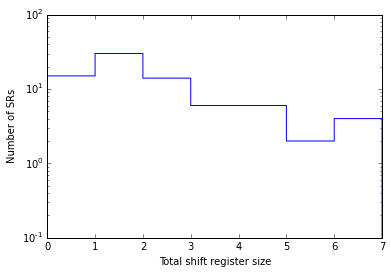

In [98]:

total_offsets = np.array(nfifo_outputs.values())
bulk_sizes = np.array(bulk_fifo_sizes.values())
fanout_sizes = np.array(fanout_fifo_sizes.values())

def print_sr_stats(all_offsets):
    print 'Total SR entries', sum(all_offsets)
    print 'Number of SR length ==0', sum(all_offsets == 0)
    print 'Number of SR length ==1', sum(all_offsets == 1)
    print 'Number of SR length ==2', sum(all_offsets == 2)
    print 'Number of SR length >=1', sum(all_offsets >= 1)
    print 'Number of SR length <=16', sum(all_offsets <= 16)
    print 'Number of SR length <=32', sum(all_offsets <= 32)
    print 'Number of SR length <=64', sum(all_offsets <= 64)
    print 'Number of SR length >64', sum(all_offsets >64)
    print 'Number of SR length >128', sum(all_offsets >128)
    print 'Number of SR length >256', sum(all_offsets >256)
    print 'Number of SR length >512', sum(all_offsets >512)

    print 'Max SR length', max(all_offsets)

print '*'*8, 'total'
print_sr_stats(total_offsets)

print '*'*8, 'bulk'
print_sr_stats(bulk_sizes)

print '*'*8, 'fanout'
print_sr_stats(fanout_sizes)

x = hist(all_offsets, np.arange(0, max(all_offsets), 1), log=True, histtype='step')
xlabel('Total shift register size')
ylabel('Number of SRs')

Total offsets 144  total sum operations 78


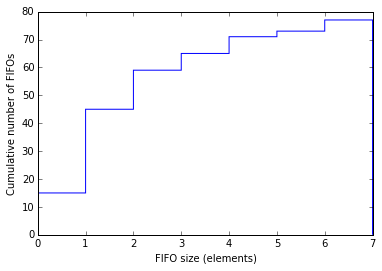

In [99]:
print 'Total offsets', sum(all_offsets), ' total sum operations', len(all_offsets)
hist(all_offsets, np.arange(0, max(all_offsets), 1), log=False, cumulative=True, histtype='step')
xlabel('FIFO size (elements)')
ylabel('Cumulative number of FIFOs')


#xlim(0, 50)

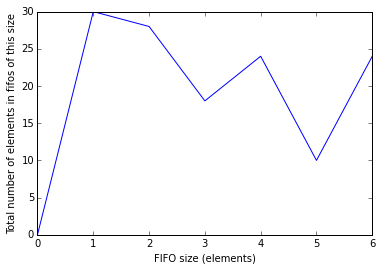

In [100]:
plot(x[1][0:-1], x[0]*(x[1][0:-1]))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos of this size')

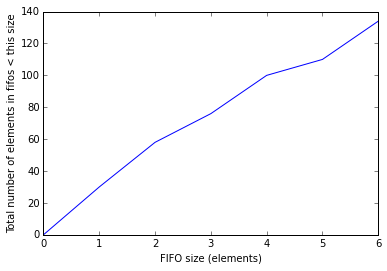

In [101]:
plot(x[1][0:-1], np.cumsum(x[0]*(x[1][0:-1])))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos < this size')

In [102]:
num_outputs = [len(ff) for ff in output_fifo_sizes.values()]
max_ff_length = [max(ff) for ff in output_fifo_sizes.values()]
ff_length_range = [max(ff) - min(ff) for ff in output_fifo_sizes.values()]

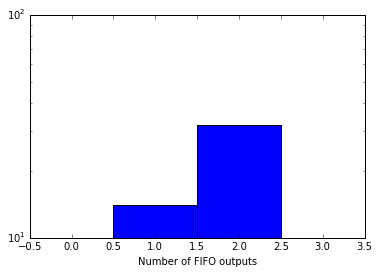

In [103]:
hist(num_outputs, np.arange(0, max(num_outputs)+3) - 0.5, log=True)
xlabel('Number of FIFO outputs')

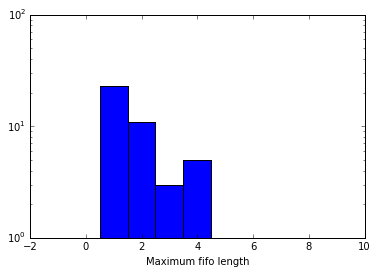

In [104]:
hist(max_ff_length, np.arange(0, max(max_ff_length)+3) - 0.5, log=True)
xlabel('Maximum fifo length')

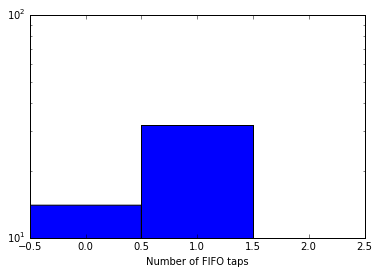

In [105]:
hist(ff_length_range, np.arange(0, max(ff_length_range)+3) - 0.5, log=True)
xlabel('Number of FIFO taps')

In [137]:
def make_c_file(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    read = '// Read inputs\n'
    for c in xrange(ishape[0]):
        for d in xrange(ishape[1]):
            read += 'fdmt_t {} = in[{}][{}];\n'.format(fmt(0, c, d), d,c)


    queuedecl = '// FIFO declarations\n\n'
    queuepush = '// FIFO push statements\n\n'
    do_sums = ''
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape
        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        
        do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        
        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += 'fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += 'fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        

    for infmt, ff_sizes in output_fifo_sizes.iteritems():
        #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
        #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
        # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
        queuedecl += 'static ap_shift_reg<fdmt_t, {}> {}_fifo;\n'.format(max(ff_sizes)+1, infmt);
        queuepush += '{}_fifo.shift({});\n'.format(infmt, infmt)
    
    # write outputs
    oshape = thefdmt.hist_state_shape[iterno+1]

    write = '\n\n// Write outputs\n\n'
    for c in xrange(oshape[0]):
        for d in xrange(oshape[1]):
            write += 'out[{}] = {};\n'.format(d, fmt(iterno+1, c, d))

                
    funcstart = '''
    void fdmt_process(fdmt_t in[ND_IN][NCHAN], fdmt_t out[ND]) {
    
    #pragma HLS PIPELINE II=16
    '''
    funcend = '''
    }
    
#
    '''
    
    fileend = "#endif"
    cfile = preamble  + queuedecl + read + do_sums + queuepush + write + fileend
    
    return cfile


s = make_c_file(thefdmt)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt)
print('Writing to ', fout)
#print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976.h')


In [107]:
configs = ((32,32), (64,64),(128,128),(256,256),(1024,256),(1024,288),(256,288),(32,288))
for nd, nchan in configs:
    thefdmt = fdmt.Fdmt(f1, chanbw, nchan, nd, Nt)
    s = make_c_file(thefdmt)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt)
    print('Writing to ', fout)
    #print(s)
    with open(fout, 'w') as fout:
        fout.write(s)

Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976.h')
Iteration 1 in=[64  3] size=192 out=[32  4] size=128
Iteration 2 in=[32  4] size=128 out=[16  6] size=96
Iteration 3 in=[16  6] size=96 out=[ 8 10] size=80
Iteration 4 in=[ 8 10] size=80 out=[ 4 18] size=72
Iteration 5 in=[ 4 18] size=72 out=[ 2 34] size=68
Iteration 6 in=[ 2 34] size=68 out=[ 1 64] size=64
('Writing to ', 'fdmt_d64_c64_f0.976.h')
Iteration 1 in=[128   3] size=384 out=[64  4] size=256
Iteration 2 in=[64  4] size=256 out=[32  6] size=192
Iteration 3 in=[32  6] size=192 out=[16 11] size=176
Iteration 4 in=[16 11] size=176 out=[ 8 20] size=160
Iteration 5 in=[ 8 20] size=160 out=[ 4 38] size=152
Iteration 6 in=[ 4 38] size=152 out=[ 2 71] size=142
Iteration 7 in=[ 2 71] size=142 out=[ 

In [154]:
def make_c_file_iter(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    
    iters = ''
    

    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape

        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        ncout, ndout = out_shape[0:2]
        ncin, ndin = in_shape[0:2]
        sums_done = set()
        queuedecl = ''
        queuedecl += '//Iteration {iterno}\n'.format(**locals())
        if ncout == 1:
            queuedecl += 'void iteration{iterno}(const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}]) \n'.format(**locals())
        else:
            queuedecl += 'void iteration{iterno}(const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}][{ncout}]) \n'.format(**locals())

        queuedecl += '{\n'
        queuedecl += '// FIFO declarations\n\n'
        queuepush = '// FIFO push statements\n\n'
        do_sums = ''
        #do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        read = ' '*4 + '// Read inputs\n'
        for c in xrange(ncin):
            for d in xrange(ndin):
                read += '    fdmt_t {} = in[{}][{}];\n'.format(fmt(iterno, c, d), d,c)
                

        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += '    fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += '    fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        
                sums_done.add((ochan, idt))
                        

        # Find FIFOS for this iteration
        myfifos = filter(lambda f: f.startswith('I{}'.format(iterno)), output_fifo_sizes)
        for infmt in myfifos:
            ff_sizes = output_fifo_sizes[infmt]
            #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
            #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
            # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
            queuedecl += '    static ap_shift_reg<fdmt_t, {}> {}_fifo;\n'.format(max(ff_sizes)+1, infmt);
            queuepush += '    {}_fifo.shift({});\n'.format(infmt, infmt)

        # write outputs
        oshape = thefdmt.hist_state_shape[iterno+1]

        write = '\n\n// Write outputs\n\n'
        for c in xrange(ncout):
            for d in xrange(ndout):
                if (c, d) in sums_done: # if the sum was actually done - load it into the array
                    write += '    out[{}][{}] = {};\n'.format(d, c , fmt(iterno+1, c, d))
                else:
                    write += '    out[{}][{}] = {};\n'.format(d, c , 0) # set the few dangling outputs to zero
                
        
        iters += queuedecl + read  + do_sums + queuepush + write + '}\n\n'
                
    funcstart = '''void fdmt_process(fdmt_t in[ND_IN][NC], fdmt_t out[ND]) { 
    #pragma HLS PIPELINE II=16
'''
    funcdecl = ''
    funcrun = ''
    lastiter = len(thefdmt.hist_nf_data) -1
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        nextiter = iterno+1
        out_shape = thefdmt.hist_state_shape[nextiter]
        in_shape = thefdmt.hist_state_shape[iterno]
        if iterno != 0:
            funcdecl += '    fdmt_t d_iter{i}[{nd}][{nc}];\n'.format(i=iterno,nc=in_shape[0], nd=in_shape[1])
            
        if iterno == 0:
            funcrun += '    iteration{iterno}(in, d_iter{nextiter});\n'.format(**locals())
        elif iterno == lastiter:
            funcrun += '    iteration{iterno}(d_iter{iterno}, out);\n'.format(**locals())
        else:
            funcrun += '    iteration{iterno}(d_iter{iterno}, d_iter{nextiter});\n'.format(**locals())

    
    funcend = '''
}
'''
    
    fileend = "#endif"
    cfile = preamble  + iters + funcstart + funcdecl + funcrun + funcend + fileend
    
    return cfile


thefdmt = fdmt.Fdmt(f1, chanbw, 32, 32, Nt)

s = make_c_file_iter(thefdmt)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter.h'.format(f=thefdmt)
print('Writing to ', fout)
print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976_iter.h')

#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd=32 nf=32 fmin=0.976 nchan=32 df=0.001 bw=0.032
//

const int NC=32; // Number of channels
const float FMIN = 0.976; // Frequency of bottom channel (GHz)
const float FMAX = 1.008; // Frequency of bottom channel (GHz)
const int ND = 32; // Number of output DM trials
const int ND_IN = 3; // number of input dm trials
const float DF = 0.001; // channel interval (GHz)
const float BW = 0.032; // Total bandwidth (GHz)

//Iteration 0
void iteration0(const fdmt_t in[3][32], fdmt_t out[4][16]) 
{
// FIFO declarations

    static ap_shift_reg<fdmt_t, 2> I0D0C1_fifo;
    static ap_shift_reg<fdm

In [155]:
configs = ((32,32), (64,64),(128,128),(256,256),(1024,256),(1024,288),(256,288),(32,288))
for nd, nchan in configs:
    thefdmt = fdmt.Fdmt(f1, chanbw, nchan, nd, Nt)
    s = make_c_file_iter(thefdmt)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter.h'.format(f=thefdmt)
    print('Writing to ', fout)
    #print(s)
    with open(fout, 'w') as fout:
        fout.write(s)

Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976_iter.h')
Iteration 1 in=[64  3] size=192 out=[32  4] size=128
Iteration 2 in=[32  4] size=128 out=[16  6] size=96
Iteration 3 in=[16  6] size=96 out=[ 8 10] size=80
Iteration 4 in=[ 8 10] size=80 out=[ 4 18] size=72
Iteration 5 in=[ 4 18] size=72 out=[ 2 34] size=68
Iteration 6 in=[ 2 34] size=68 out=[ 1 64] size=64
('Writing to ', 'fdmt_d64_c64_f0.976_iter.h')
Iteration 1 in=[128   3] size=384 out=[64  4] size=256
Iteration 2 in=[64  4] size=256 out=[32  6] size=192
Iteration 3 in=[32  6] size=192 out=[16 11] size=176
Iteration 4 in=[16 11] size=176 out=[ 8 20] size=160
Iteration 5 in=[ 8 20] size=160 out=[ 4 38] size=152
Iteration 6 in=[ 4 38] size=152 out=[ 2 71] size=142
Iteration 7 in=[ 2 71] size=